In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import xgboost as xgb

## Part 1. Read data from csv file and preprocessing

Read the CSV file and observe the structure of the data. Since it only gives the timestamp and the speed of the corresponding time, so we need to do EDA(exploratory data analysis) and see which time data has a significant effect on the speed.

In [3]:
trafficFile = 'train.csv'
traffic = pd.read_csv(trafficFile, index_col="id", parse_dates=[1], dayfirst=True)
# traffic = traffic.drop(columns='id')
traffic.head()

,date,speed
id,,
0,2017-01-01 00:00:00,43.002930
1,2017-01-01 01:00:00,46.118696
2,2017-01-01 02:00:00,44.294158
3,2017-01-01 03:00:00,41.067468
4,2017-01-01 04:00:00,46.448653


Based on EDA, we can discover that there is a big difference in the distribution of traffic speed between weekdays and weekends. Meanwhile, through the average velocity distribution, we can see that the velocity of identical months and each day within each month has a large fluctuation. So it's admirable to take month, date, day of week, and hour as the feature of the model, and also include the given timestamp as an analysis feature after normalization

In [4]:
traffic['hour'] = pd.to_datetime(traffic['date']).apply(lambda x: x.hour)
traffic['hour'] = traffic['hour']/23
traffic['weekday'] = pd.to_datetime(traffic['date']).apply(lambda x: x.dayofweek)
traffic['weekday'] = traffic['weekday']/6
traffic['month']=pd.to_datetime(traffic['date']).apply(lambda x:x.month)
traffic['month']=traffic['month']/12
traffic['day']=pd.to_datetime(traffic['date']).apply(lambda x:x.day)
traffic['day']=traffic['day']/30
max_time = max(traffic['date'])
min_time = min(traffic['date'])
traffic['time'] = (traffic['date']-min_time)/(max_time-min_time)

Set parameters for the dataset and split the original dataset into a training dataset and a testing one.

In [5]:
from sklearn.model_selection import train_test_split
X = traffic[['time','weekday','hour','month','day']]
y = traffic['speed']

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.04,random_state=0)

## Part2. Regression and Plot the result

In [6]:
def regression_method(x_train,y_train,model):
    model.fit(x_train,y_train)
    score = model.score(x_test, y_test)
    result = model.predict(x_test)
    ResidualSquare = (result - y_test)**2
    RSS = sum(ResidualSquare)
    MSE = np.mean(ResidualSquare)
    num_regress = len(result)
    print(f'n={num_regress}')
    print(f'R^2={score}')
    print(f'MSE={MSE}')
    print(f'RSS={RSS}')
    # Draw line chart to show the difference between the predicting value and actual value
    plt.figure(figsize=(20,8),dpi=80)
    # Verify with scatter plot, points that are closer to the 1:1 line means that the corresponding predicting value is closer to its actual value
    plt.plot(np.arange(len(result)), y_test,'go-',label='true value')
    plt.plot(np.arange(len(result)),result,'ro-',label='predict value')
    plt.title('RandomForestRegression R^2: %f'%score)
    plt.legend()
    plt.show()
    return result,model

In [7]:
# Verify with scatter plot, points that are closer to the 1:1 line means that the corresponding predicting value is closer to its actual value
def scatter_plot(TureValues,PredictValues):
    # set the referenced 1:1 line
    xxx = [10,50]
    yyy = [10,50]
    plt.figure()
    plt.plot(xxx , yyy , c='0' , linewidth=1 , linestyle=':' , marker='.' , alpha=0.3)
    # scatter plot, whose x represents actural value and y represents predicting value
    plt.scatter(TureValues , PredictValues , s=20 , c='r' , edgecolors='k' , marker='o' , alpha=0.8)
    plt.xlim((10,50))
    plt.ylim((10,50))
    plt.title('RandomForestRegressionScatterPlot')
    plt.show()

In [8]:
my_model = xgb.XGBRegressor(learning_rate=0.1,n_estimators=500,max_depth=10,
                            min_child_weight=1,subsample=0.8,colsample_bytree=0.8,
                           gamma=0,reg_alpha=0,reg_lambda=1,n_jobs=-1)

n=561
R^2=0.9457503033529675
MSE=10.173506394625765
RSS=5707.3370873850545


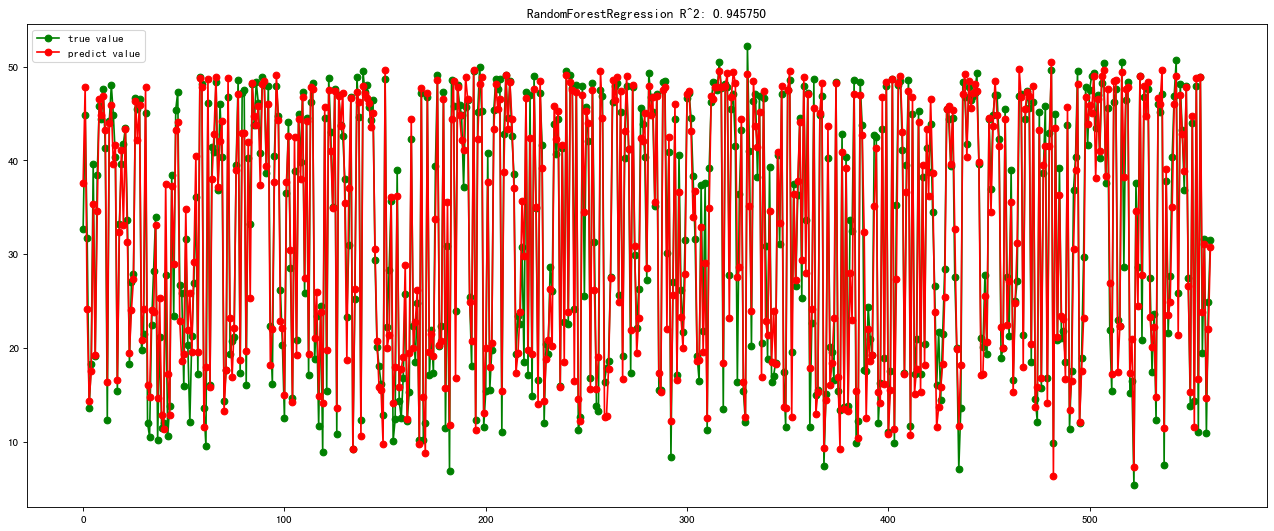

In [9]:
# get the predicting result, accuracy, and plot that represents difference between predicted value and actual value
y_pred,trained_model = regression_method(x_train,y_train,my_model)

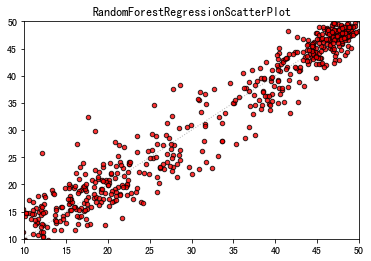

In [10]:
scatter_plot(y_test,y_pred)

## Part3. Adjust the parameters of the model and reach an admirable result

Due to the limitation of computer performance, we only adjust parameters one by one or set some related parameters as a group to adjust

### (1) n_estimator

Number of gradient boosted trees. Equivalent to number of boosting rounds. The larger the n_estimator, the better performance of xgboost Regressor, but after certain round, increasing this parameter will not increase the performance significantly

In [40]:
cv_params = {'n_estimators': range(300,501,10)}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized1 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=6)
optimized1.fit(x_train, y_train)
optimized1.cv_results_, optimized1.best_params_, optimized1.best_score_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   18.3s
[Parallel(n_jobs=6)]: Done 105 out of 105 | elapsed:   50.6s finished


({'mean_fit_time': array([2.58201246, 2.06214762, 2.00784349, 2.12540503, 2.20026259,
         2.23636308, 2.40852723, 2.31735191, 2.39666257, 2.49262872,
         2.66588812, 2.60058942, 2.66501141, 2.83632245, 2.81774492,
         2.85664487, 2.93693342, 2.98673382, 3.05272732, 3.05154858,
         2.91364803]),
  'std_fit_time': array([0.08512689, 0.27724364, 0.06797727, 0.10231931, 0.12460906,
         0.03512361, 0.12479826, 0.06330451, 0.08106314, 0.07351737,
         0.07972702, 0.02293388, 0.05850615, 0.0687731 , 0.05523505,
         0.03927486, 0.04834156, 0.05778449, 0.06992116, 0.09589966,
         0.22509344]),
  'mean_score_time': array([0.08836398, 0.09489346, 0.08858981, 0.09025154, 0.09464002,
         0.10234408, 0.09703441, 0.10413671, 0.10269279, 0.1067862 ,
         0.12927442, 0.13739381, 0.13165183, 0.120544  , 0.12336164,
         0.14099216, 0.15515194, 0.14291019, 0.13521814, 0.14090123,
         0.11921544]),
  'std_score_time': array([0.0285858 , 0.02244752, 

In [41]:
cv_params = {'n_estimators': range(100,301,10)}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized1 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=6)
optimized1.fit(x_train, y_train)
optimized1.cv_results_, optimized1.best_params_, optimized1.best_score_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.1s
[Parallel(n_jobs=6)]: Done 105 out of 105 | elapsed:   24.4s finished


({'mean_fit_time': array([0.63436089, 0.7295362 , 0.78185415, 0.84921761, 0.90112314,
         0.96469049, 1.03172603, 1.10462089, 1.20226145, 1.34064298,
         1.40734015, 1.52686782, 1.45976844, 1.58582182, 1.57108049,
         1.59620061, 1.68081374, 1.71647406, 1.79874344, 1.87485509,
         1.79598045]),
  'std_fit_time': array([0.0211812 , 0.01962016, 0.0360526 , 0.01309433, 0.01762651,
         0.02372347, 0.01205646, 0.04547744, 0.03475541, 0.05297177,
         0.0639283 , 0.06516429, 0.03234132, 0.04111556, 0.03265977,
         0.0304195 , 0.01652348, 0.03090887, 0.02619127, 0.0284038 ,
         0.15291372]),
  'mean_score_time': array([0.01571002, 0.01810126, 0.01691093, 0.01850834, 0.02214861,
         0.02582359, 0.02133703, 0.0293725 , 0.03453698, 0.03659277,
         0.04145422, 0.05190229, 0.05305586, 0.04670029, 0.04458108,
         0.05311918, 0.05186486, 0.06043482, 0.06604576, 0.07126031,
         0.05809369]),
  'std_score_time': array([0.00467826, 0.00402669, 

In [42]:
cv_params = {'n_estimators': range(140,161,1)}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized1 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=6)
optimized1.fit(x_train, y_train)
optimized1.cv_results_, optimized1.best_params_, optimized1.best_score_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.6s
[Parallel(n_jobs=6)]: Done 105 out of 105 | elapsed:   17.7s finished


({'mean_fit_time': array([0.87764373, 0.90014777, 0.91237202, 0.90879459, 0.95013633,
         0.95651388, 0.92972765, 0.94460902, 0.97188883, 0.95080175,
         0.97048512, 0.97361684, 0.95973091, 0.97989693, 1.00002637,
         1.00913148, 1.0080842 , 1.00716357, 1.00848603, 1.01191339,
         0.92117286]),
  'std_fit_time': array([0.03642991, 0.02267768, 0.00814692, 0.03317814, 0.00938182,
         0.04703462, 0.04968712, 0.02473733, 0.01857516, 0.01760429,
         0.03968189, 0.02497942, 0.03655057, 0.02381276, 0.03236354,
         0.01501092, 0.02728861, 0.01738001, 0.02744704, 0.01879787,
         0.06674717]),
  'mean_score_time': array([0.02458715, 0.02387295, 0.02266269, 0.0273828 , 0.02255898,
         0.02213979, 0.02617974, 0.02534933, 0.02357731, 0.02468967,
         0.02207637, 0.03208885, 0.02640986, 0.0292357 , 0.02597775,
         0.02583256, 0.02622328, 0.02779613, 0.02546988, 0.02565227,
         0.02453327]),
  'std_score_time': array([0.00466676, 0.00441597, 

### (2) max_depth && min_child_weight

'max_depth' is the maximum depth of a tree, 'min_child_weight' defines the minimum sum of weights of all observations required in a child. Both works for avoiding overfitting, the smaller the depth, the higher the min_child_weight, the better model generalization.

In [43]:
cv_params = {'max_depth': range(4,15,2), 'min_child_weight': range(1,7,1)}
other_params = {'learning_rate': 0.1, 'n_estimators': 148, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized1 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
optimized1.fit(x_train, y_train)
optimized1.cv_results_, optimized1.best_params_, optimized1.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   27.0s finished


({'mean_fit_time': array([1.52797737, 2.12490735, 1.1503336 , 0.64665318, 0.71794381,
         0.72555461, 0.98167806, 0.98334928, 0.96316047, 1.0025455 ,
         0.97109404, 0.96464701, 1.25649114, 1.23818889, 1.25148344,
         1.24113054, 1.22854557, 1.23847899, 1.53225636, 1.53540044,
         1.51865754, 1.51946507, 1.51932292, 1.49979863, 1.89740582,
         1.85521212, 1.89373302, 1.89587145, 1.85725236, 2.05276837,
         2.34660187, 2.23970203, 2.1904417 , 2.14973092, 2.08994732,
         1.87511387]),
  'std_fit_time': array([0.51352213, 0.01704253, 0.78704404, 0.11944422, 0.01573542,
         0.02126009, 0.01502855, 0.01334851, 0.0169966 , 0.02467786,
         0.01371741, 0.00665658, 0.0099885 , 0.012653  , 0.00923324,
         0.01207355, 0.0160133 , 0.01085275, 0.01664681, 0.02350741,
         0.02144591, 0.02578653, 0.02056483, 0.01341503, 0.01576775,
         0.01175102, 0.06997829, 0.07768616, 0.02039547, 0.07650373,
         0.02026319, 0.03821436, 0.02374017, 0.

In [45]:
cv_params = {'max_depth': range(8,13,1), 'min_child_weight': [0.8,0.9,1.0,1.1,1.2]}
other_params = {'learning_rate': 0.1, 'n_estimators': 148, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized1 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
optimized1.fit(x_train, y_train)
optimized1.cv_results_, optimized1.best_params_, optimized1.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   17.7s finished


({'mean_fit_time': array([1.37471628, 1.28889632, 1.28019938, 1.2408504 , 1.25858259,
         1.46222053, 1.50779452, 1.45956526, 1.49834852, 1.47570972,
         1.54593797, 1.53057718, 1.548033  , 1.55612192, 1.55708065,
         1.70142131, 1.74128189, 1.70456834, 1.66797237, 1.67591367,
         1.88442841, 1.8992003 , 1.9167551 , 1.87677202, 1.58660512]),
  'std_fit_time': array([0.12316063, 0.10373992, 0.0779457 , 0.01063566, 0.03538509,
         0.02959397, 0.03250112, 0.04473303, 0.07454715, 0.08957286,
         0.02149201, 0.01363658, 0.00834162, 0.02136243, 0.02883605,
         0.01554571, 0.03216228, 0.01405272, 0.0082639 , 0.01372128,
         0.03549894, 0.02345579, 0.03574183, 0.01867074, 0.07359466]),
  'mean_score_time': array([0.0380549 , 0.03594108, 0.03534436, 0.03513417, 0.03519149,
         0.05639839, 0.05387545, 0.05134754, 0.04010243, 0.04095168,
         0.05432367, 0.05647345, 0.05080438, 0.05434813, 0.0514801 ,
         0.06767626, 0.07944593, 0.06208162, 0.

So the best max_depth and min_child_weight is 10 and 1.0

### (3) gamma

Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.

In [46]:
cv_params = {'gamma': [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4]}
other_params = {'learning_rate': 0.1, 'n_estimators': 148, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized1 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
optimized1.fit(x_train, y_train)
optimized1.cv_results_, optimized1.best_params_, optimized1.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.3s finished


({'mean_fit_time': array([1.57828789, 1.56843944, 1.53870907, 1.52909045, 1.5366818 ,
         1.54193602, 1.52999182, 1.422335  , 1.37793922]),
  'std_fit_time': array([0.04299003, 0.02983349, 0.00855594, 0.01280535, 0.01530549,
         0.01709276, 0.01346796, 0.05585996, 0.03834686]),
  'mean_score_time': array([0.08546376, 0.09261379, 0.08306313, 0.08098803, 0.08118973,
         0.08727169, 0.08548694, 0.06417184, 0.05335364]),
  'std_score_time': array([0.00730335, 0.01793518, 0.0148412 , 0.01441814, 0.01080755,
         0.01015987, 0.00451619, 0.01441005, 0.01060462]),
  'param_gamma': masked_array(data=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0},
   {'gamma': 0.05},
   {'gamma': 0.1},
   {'gamma': 0.15},
   {'gamma': 0.2},
   {'gamma': 0.25},
   {'gamma': 0.3},
   {'gamma': 0.35},
   {'gamma

In [47]:
cv_params = {'gamma': np.linspace(0.05,0.15,11)}
other_params = {'learning_rate': 0.1, 'n_estimators': 148, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized1 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
optimized1.fit(x_train, y_train)
optimized1.cv_results_, optimized1.best_params_, optimized1.best_score_

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    8.0s finished


({'mean_fit_time': array([1.55462532, 1.5483634 , 1.56571369, 1.56919079, 1.55230455,
         1.53954353, 1.54573689, 1.5356946 , 1.61492939, 1.53722925,
         1.33488674]),
  'std_fit_time': array([0.0217376 , 0.03292513, 0.02549184, 0.02602992, 0.01887449,
         0.02013934, 0.01222989, 0.05000852, 0.01633627, 0.13251072,
         0.04838607]),
  'mean_score_time': array([0.08389359, 0.08409114, 0.08449979, 0.07964716, 0.06742706,
         0.0802217 , 0.0824913 , 0.0618989 , 0.07947483, 0.06088829,
         0.047435  ]),
  'std_score_time': array([0.00677507, 0.01516019, 0.00984054, 0.01017805, 0.01514786,
         0.012448  , 0.00270773, 0.01120087, 0.01721855, 0.01268073,
         0.01253099]),
  'param_gamma': masked_array(data=[0.05, 0.06, 0.07, 0.08, 0.09, 0.09999999999999999,
                     0.10999999999999999, 0.12, 0.13, 0.13999999999999999,
                     0.15],
               mask=[False, False, False, False, False, False, False, False,
                   

So the best gamma is 0.1

### (4) subsample && colsample_bytree

Also aiming at avoiding overfitting. 'subsample' denotes the fraction of observations to be randomly samples for each tree. 'colsample_bytree' denotes the fraction of columns to be randomly samples for each tree, as the nuumber of feature selected for this model is small, usually we keep 'colsample_bytree' to be one.

In [48]:
cv_params = {'subsample': [0.6, 0.7, 0.8, 0.9,1.0], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9,1.0]}
other_params = {'learning_rate': 0.1, 'n_estimators': 148, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized1 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
optimized1.fit(x_train, y_train)
optimized1.cv_results_, optimized1.best_params_, optimized1.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   17.1s finished


({'mean_fit_time': array([1.43454266, 1.40042691, 1.34925528, 1.31988249, 1.21717844,
         1.41023259, 1.37189341, 1.34915643, 1.3177176 , 1.21865163,
         1.61503077, 1.58936234, 1.59608607, 1.54459267, 1.41001339,
         1.64557943, 1.57236567, 1.5617847 , 1.52095542, 1.42756062,
         1.84042211, 1.77204413, 1.74032178, 1.7122077 , 1.33350687]),
  'std_fit_time': array([0.00983713, 0.01898192, 0.01773854, 0.01116976, 0.01727241,
         0.02481038, 0.01185943, 0.01671627, 0.01225775, 0.02208148,
         0.00957136, 0.02033661, 0.01462985, 0.02161384, 0.03176823,
         0.05474914, 0.02043416, 0.02319458, 0.00865778, 0.04378669,
         0.03372282, 0.02624964, 0.0235547 , 0.01105107, 0.14008175]),
  'mean_score_time': array([0.0843154 , 0.09092498, 0.08607373, 0.07337666, 0.06256304,
         0.07373328, 0.08271389, 0.05990181, 0.08227835, 0.05694194,
         0.07186723, 0.07213216, 0.06749759, 0.06414866, 0.04639387,
         0.07424021, 0.07244592, 0.06049795, 0.

In [49]:
cv_params = {'subsample': [0.77,0.78,0.79,0.8,0.81,0.82], 'colsample_bytree': np.linspace(0.9,1.3,5)}
other_params = {'learning_rate': 0.1, 'n_estimators': 148, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized1 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
optimized1.fit(x_train, y_train)
optimized1.cv_results_, optimized1.best_params_, optimized1.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 127 out of 150 | elapsed:    8.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    8.7s finished


({'mean_fit_time': array([1.56038022, 1.55452824, 1.5441329 , 1.53608913, 1.54013543,
         1.54354095, 1.74514503, 1.73606529, 1.7401536 , 1.71209631,
         1.76626124, 1.74062133, 0.00967002, 0.00926137, 0.00967193,
         0.0077033 , 0.00849719, 0.00847206, 0.00968432, 0.00645208,
         0.01009183, 0.01052079, 0.00849013, 0.00526862, 0.00765576,
         0.01011615, 0.00484219, 0.00967059, 0.00645366, 0.00604167]),
  'std_fit_time': array([2.36764940e-02, 1.46178922e-02, 1.75312578e-02, 1.36563792e-02,
         2.26042053e-02, 3.00766452e-02, 2.33039033e-02, 2.31915544e-02,
         2.66123094e-02, 1.51454773e-02, 3.41284319e-02, 3.51358618e-02,
         8.15981392e-04, 9.89140753e-04, 8.06260867e-04, 2.97381948e-03,
         3.23034238e-03, 3.22193571e-03, 8.25761611e-04, 4.48223866e-03,
         9.11046028e-06, 6.55459812e-03, 3.21297269e-03, 3.93860062e-03,
         3.90953202e-03, 6.40442530e-03, 3.50380770e-03, 8.19592218e-04,
         3.68916320e-03, 4.21939514e-03]

So the best sub_sample, colsample_bytree is 0.82 and 1.0

### (5) reg_alpha && reg_lambda

reg_alpha is the l1 regularization term on weight, while reg_lambda is the l2 regularization ter on weights. Also work as ways to avoid overfitting.

In [50]:
cv_params = {'reg_alpha': [0.05,0.1,0.5,1,1.5,2,3], 'reg_lambda': [0.05,0.1,0.5,1,1.5,2,3]}
other_params = {'learning_rate': 0.1, 'n_estimators': 148, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.82, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized1 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
optimized1.fit(x_train, y_train)
optimized1.cv_results_, optimized1.best_params_, optimized1.best_score_

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:   38.5s finished


({'mean_fit_time': array([1.81195769, 1.78497405, 1.77828698, 1.7736249 , 1.74073663,
         1.73485041, 1.73068109, 1.76033549, 1.73876429, 1.75305595,
         1.78457398, 1.73647618, 1.72789454, 1.74858003, 1.77287722,
         1.76641889, 1.75443273, 1.79405718, 1.7845397 , 1.79487491,
         1.81480842, 1.80297303, 1.83473101, 1.84531021, 1.76184464,
         1.77658672, 1.94241495, 1.94972591, 1.82787552, 1.87003779,
         1.85030279, 1.79820976, 1.79667583, 1.78135438, 1.77199202,
         1.80089703, 1.76503878, 1.78477693, 1.7690516 , 1.78150277,
         1.77480426, 1.74608798, 1.77845116, 1.78256383, 1.77565465,
         1.78534174, 1.75668454, 1.75914965, 1.41338992]),
  'std_fit_time': array([0.02491023, 0.0151982 , 0.01519448, 0.01096952, 0.02388336,
         0.00794963, 0.00431569, 0.0250461 , 0.01312226, 0.02809628,
         0.03289861, 0.01102269, 0.01285238, 0.00619896, 0.02936087,
         0.00945994, 0.01140673, 0.01357616, 0.03206695, 0.02862172,
         0.

In [51]:
cv_params = {'reg_alpha': np.linspace(0.05,0.5,10), 'reg_lambda': [2.5,3,3.5,4,4.5,5]}
other_params = {'learning_rate': 0.1, 'n_estimators': 148, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.82, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized1 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
optimized1.fit(x_train, y_train)
optimized1.cv_results_, optimized1.best_params_, optimized1.best_score_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   46.4s finished


({'mean_fit_time': array([1.74839616, 1.75043058, 1.75424867, 1.75384259, 1.74638004,
         1.74307308, 1.7505475 , 1.78767319, 1.83589563, 1.80302138,
         1.81723809, 1.80205803, 1.81322613, 1.97213449, 1.97010708,
         1.95998816, 2.24124899, 1.89455047, 1.89987082, 1.81542163,
         1.79362054, 1.80967526, 1.81885905, 1.82926841, 1.78918552,
         1.79030619, 1.75436893, 1.74120665, 1.73342938, 1.73888988,
         1.74716668, 1.72847548, 1.74178791, 1.7459187 , 1.7488719 ,
         1.73907552, 1.75176482, 1.74926028, 1.73489842, 1.73669047,
         1.72421708, 1.73022676, 1.7458909 , 1.73792663, 1.74819016,
         1.74729023, 1.77299852, 1.77363701, 1.75755639, 1.76204081,
         1.74692187, 1.73203607, 1.75810461, 1.76230783, 1.79524159,
         1.7372982 , 1.73425035, 1.74562416, 1.74851584, 1.58401523]),
  'std_fit_time': array([0.02262196, 0.01195435, 0.02585176, 0.01230274, 0.0192876 ,
         0.02507417, 0.03452615, 0.04998704, 0.05590966, 0.06067398,

In [52]:
cv_params = {'reg_alpha': np.linspace(0.35,0.45,11), 'reg_lambda': [5,5.5,6,6.5,7]}
other_params = {'learning_rate': 0.1, 'n_estimators': 148, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.82, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized1 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
optimized1.fit(x_train, y_train)
optimized1.cv_results_, optimized1.best_params_, optimized1.best_score_

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:   41.5s finished


({'mean_fit_time': array([1.74377837, 1.73936276, 1.76527338, 1.80547104, 1.74059258,
         1.74522119, 1.80256958, 1.79329195, 1.78856544, 1.80658836,
         1.80738282, 1.80779481, 1.75489717, 1.76354523, 1.76488829,
         1.77107501, 1.74694982, 1.74908361, 1.767414  , 1.76336074,
         1.73712826, 1.71945882, 1.72169042, 1.72602367, 1.73074851,
         1.75068841, 1.72599287, 1.72516623, 1.73759933, 1.74308114,
         1.73953176, 1.72816539, 1.72870607, 1.7535028 , 1.73911757,
         1.72895465, 1.72725635, 1.73457041, 1.73170385, 1.73939905,
         1.72879219, 1.73128815, 1.72799215, 1.74199648, 1.73193598,
         1.72805719, 1.75645852, 1.73428817, 1.7297689 , 1.75649762,
         1.72620378, 1.72669606, 1.72444153, 1.66782565, 1.65134692]),
  'std_fit_time': array([0.03059562, 0.01355347, 0.02716768, 0.01665092, 0.025805  ,
         0.02928828, 0.03236848, 0.03914531, 0.05109481, 0.0641342 ,
         0.07340131, 0.01991236, 0.03400215, 0.02055644, 0.01088208,

In [53]:
cv_params = {'reg_alpha': np.linspace(0.38,0.42,5), 'reg_lambda': np.linspace(4.5,5.5,11)}
other_params = {'learning_rate': 0.1, 'n_estimators': 148, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.82, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 1,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized1 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
optimized1.fit(x_train, y_train)
optimized1.cv_results_, optimized1.best_params_, optimized1.best_score_

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:   41.7s finished


({'mean_fit_time': array([1.7320322 , 1.72412462, 1.73582072, 1.7302022 , 1.71781173,
         1.7529892 , 1.75007567, 1.75800581, 1.75258703, 1.72238441,
         1.72960749, 1.71147532, 1.74406862, 1.74144282, 1.73224187,
         1.73539286, 1.73123889, 1.73671026, 1.7250772 , 1.73465328,
         1.74002123, 1.74908085, 1.72961864, 1.74388843, 1.73863235,
         1.74096761, 1.75711741, 1.79573188, 1.76022487, 1.80507765,
         1.78626323, 1.77056293, 1.77982965, 1.77495995, 1.79169612,
         1.80608597, 1.73409781, 1.73551397, 1.72390385, 1.75050292,
         1.75388479, 1.72171741, 1.745819  , 1.73792424, 1.73311625,
         1.7329915 , 1.73007803, 1.7356636 , 1.74343839, 1.75377998,
         1.73583221, 1.72834668, 1.71483965, 1.63320084, 1.62177577]),
  'std_fit_time': array([0.01860582, 0.00816003, 0.01061951, 0.01771934, 0.01393232,
         0.0144432 , 0.01070515, 0.02770523, 0.03412758, 0.0128453 ,
         0.02492519, 0.01216483, 0.0135328 , 0.01592694, 0.01910202,

So the best reg_alpha and reg_lambda is 4.6 and 0.39

### (6) learning_rate

A higher learning rate helps the model converge quicker, but it may affect the precision, so we need to check whether lowering the learning rate may lead to a better result.

In [54]:
cv_params = {'learning_rate': [0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15]}
other_params = {'learning_rate': 0.1, 'n_estimators': 148, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.82, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0.39, 'reg_lambda': 4.6,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized1 = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
optimized1.fit(x_train, y_train)
optimized1.cv_results_, optimized1.best_params_, optimized1.best_score_

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    8.7s finished


({'mean_fit_time': array([1.76020112, 1.78686376, 1.75993595, 1.76766863, 1.76306176,
         1.71337185, 1.75181723, 1.75019836, 1.7466826 , 1.62561383,
         1.44545851]),
  'std_fit_time': array([0.0257254 , 0.01408384, 0.02478777, 0.04664621, 0.03471305,
         0.01625848, 0.03141072, 0.03516783, 0.01986772, 0.14242444,
         0.04293042]),
  'mean_score_time': array([0.07440176, 0.07392344, 0.05933552, 0.05624537, 0.06290374,
         0.05886345, 0.06812315, 0.0652411 , 0.05768728, 0.04816256,
         0.040832  ]),
  'std_score_time': array([0.00597042, 0.00733231, 0.01988711, 0.00868031, 0.00410389,
         0.0087805 , 0.01194992, 0.00828705, 0.00859066, 0.00666044,
         0.00575149]),
  'param_learning_rate': masked_array(data=[0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13,
                     0.14, 0.15],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False],
         fill_value='?',
          

In [55]:
cv_params = {'n_estimators': range(140,161,1)}
other_params = {'learning_rate': 0.1, 'n_estimators': 148, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.82, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0.39, 'reg_lambda': 4.6,
                'n_jobs':-1}

model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=6)
optimized_GBM.fit(x_train, y_train)
evalute_result = optimized_GBM.cv_results_
print('best score each round:{0}'.format(evalute_result))
print('best parameter：{0}'.format(optimized_GBM.best_params_))
print('best score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   10.2s
[Parallel(n_jobs=6)]: Done 105 out of 105 | elapsed:   22.8s finished


best score each round:{'mean_fit_time': array([1.68535295, 1.13129687, 1.00485258, 1.02808938, 1.04396534,
       1.01432538, 1.04039588, 1.04566832, 1.07836285, 1.13624735,
       1.14359241, 1.10507169, 1.11295609, 1.1380682 , 1.1492156 ,
       1.14068184, 1.12132807, 1.13214397, 1.12378106, 1.13973484,
       1.05166149]), 'std_fit_time': array([0.17914628, 0.34123522, 0.03647915, 0.03481211, 0.0234575 ,
       0.02731293, 0.02943797, 0.01655568, 0.01896909, 0.06702821,
       0.07254948, 0.04619625, 0.0149036 , 0.039364  , 0.02144261,
       0.03569582, 0.0277139 , 0.02386663, 0.02755215, 0.0234638 ,
       0.0925181 ]), 'mean_score_time': array([0.02695246, 0.02319212, 0.02394099, 0.02474236, 0.02199211,
       0.02170086, 0.02181029, 0.02471938, 0.02434731, 0.02170048,
       0.02595248, 0.02093134, 0.02690053, 0.02508616, 0.02389574,
       0.02447228, 0.02213044, 0.02688856, 0.02527599, 0.02376938,
       0.02298098]), 'std_score_time': array([0.00356387, 0.00370872, 0.0026960

## Part4. Apply all adjustments and see the improvement in performance

n=561
R^2=0.9490309465270323
MSE=9.558283704497418
RSS=5362.197158223052


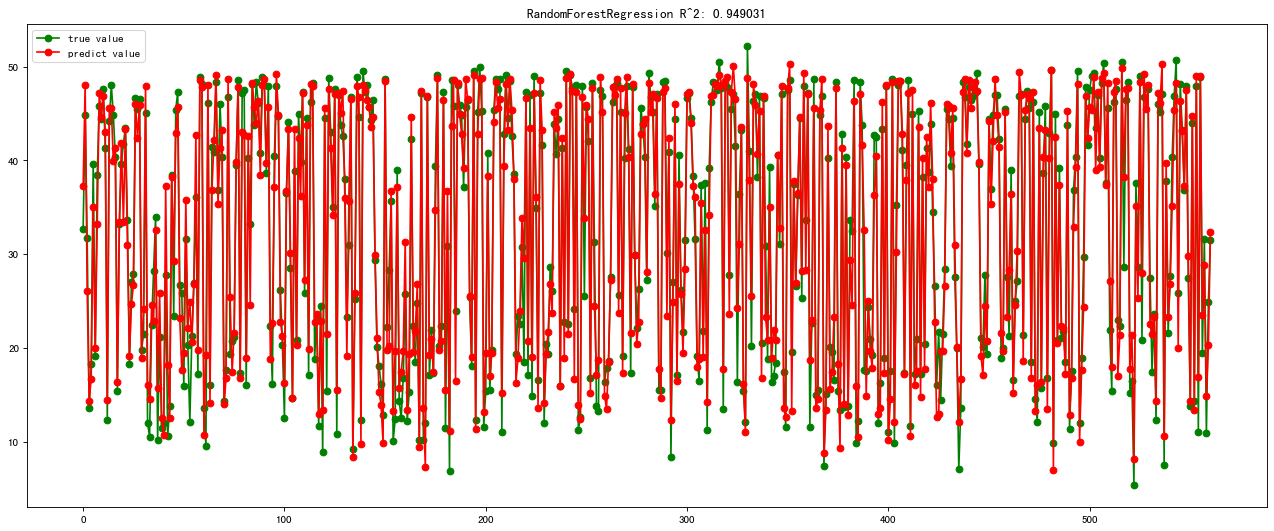

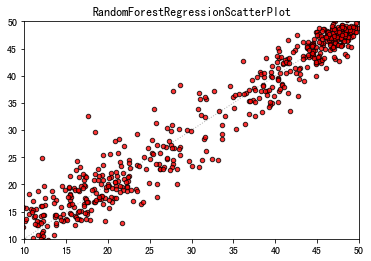

In [11]:
xgb_processed = xgb.XGBRegressor(learning_rate=0.1,n_estimators=500,max_depth=10,
                            min_child_weight=1,subsample=0.82,colsample_bytree=1,
                           gamma=0.1,reg_alpha=0.39,reg_lambda=4.6,n_jobs=-1)
# get the trained model and apply it to data in 'test.csv'
y_pred,trained_model = regression_method(x_train,y_train,xgb_processed)
scatter_plot(y_test,y_pred)  #生成散点图

## Part 5. Read test data and get prediction result

In [12]:
data_test = pd.read_csv("test.csv", index_col='id', parse_dates=[1], dayfirst=True)
# data_test['datetime'] = pd.to_datetime(data_test['date'])
data_test['hour'] = pd.to_datetime(data_test['date']).apply(lambda x: x.hour)
data_test['hour'] = data_test['hour']/23
data_test['weekday'] = pd.to_datetime(data_test['date']).apply(lambda x: x.dayofweek)
data_test['weekday'] = data_test['weekday']/6
data_test['month'] = pd.to_datetime(data_test['date']).apply(lambda x:x.month)
data_test['month'] = data_test['month']/12
data_test['day'] = pd.to_datetime(data_test['date']).apply(lambda x:x.day)
data_test['day'] = data_test['day']/30
data_test['time'] = (data_test['date']-min_time)/(max_time-min_time)
data_test.head()

,date,hour,weekday,month,day,time
id,,,,,,
0,2018-01-01 02:00:00,0.086957,0.0,0.083333,0.033333,0.500228
1,2018-01-01 05:00:00,0.217391,0.0,0.083333,0.033333,0.500400
2,2018-01-01 07:00:00,0.304348,0.0,0.083333,0.033333,0.500514
3,2018-01-01 08:00:00,0.347826,0.0,0.083333,0.033333,0.500571
4,2018-01-01 10:00:00,0.434783,0.0,0.083333,0.033333,0.500685


In [13]:
predict_x = data_test[['time','weekday','hour','month','day']]
predict_x.shape

(3504, 5)

In [14]:
y = xgb_processed.fit(X,y).predict(predict_x)

## Part6. Save results in the required form

In [15]:
y = y.reshape(-1,1)

index = np.arange(len(y))
index = index.reshape(-1,1)

df = pd.DataFrame(dict(date=data_test['date'].ravel(), id=index.ravel()))
df.drop(['date'], axis=1, inplace=True)
df = pd.DataFrame(dict(id=df['id'].ravel(), speed=y.ravel()))
df

,id,speed
0,0,48.559910
1,1,48.242973
2,2,35.777866
3,3,30.482962
4,4,38.206345
...,...,...
3499,3499,12.883239
3500,3500,24.489723
3501,3501,44.562405
3502,3502,40.223949


In [16]:
df.to_csv("xgboost_model3_pred.csv",index=False)